# Kuhn Counterfactual Regret Minimization Agent

In [1]:
from IPython.display import Image
Image(filename = 'Kuhn_Rule.png', width=800, height=800)

In [3]:
# https://docs.python.org/3/library/random.html
import random
import numpy as np
from matplotlib import pyplot as plt
# need the ipywidgets jlab extension to be installed 
# https://github.com/intake/intake/issues/148
from tqdm import tqdm_notebook as tqdm 

# Kuhn Poker definitions
PASS = 0
BET = 1
NUM_ACTIONS = 2
nodeDict = {}

In [4]:
# Information set node class definition
class Node:
    # Kuhn node definitions
    infoSet = ''
    regretSum = np.zeros(NUM_ACTIONS)
    strategy = np.zeros(NUM_ACTIONS)
    strategySum = np.zeros(NUM_ACTIONS)
    
    # Init
    def __init__(self, infoSet):
        self.infoSet = infoSet
    
    # Update Regret
    def updateRegret(self, regret):
        self.regretSum = self.regretSum + regret
    
    # Get current information set mixed strategy through regret-matching
    def getStrategy(self, realizationWeight):
        strategy = np.maximum(self.regretSum, np.zeros(NUM_ACTIONS))
        if (np.sum(strategy) > 0):
            strategy = strategy/np.sum(strategy)
        else:
            strategy = np.ones(NUM_ACTIONS)/NUM_ACTIONS
        self.strategySum = self.strategySum + realizationWeight*strategy

        return(strategy)
    
    # Get average information set mixed strategy across all training iterations
    def getAverageStrategy(self):
        avgStrategy = np.zeros(NUM_ACTIONS)

        if (np.sum(self.strategySum) > 0):
            avgStrategy = self.strategySum/np.sum(self.strategySum)
        else:
            avgStrategy = np.ones(NUM_ACTIONS)/NUM_ACTIONS
        return(avgStrategy)
    
    # Get information set string representation
    def toString(self):
        avgStrategy = self.getAverageStrategy()
        formatted_str = '{}: {}'.format(self.infoSet, np.array2string(avgStrategy))
        return(formatted_str)

In [5]:
# Counterfactual regret minimization iteration
def cfr(cards, history, p0, p1, level = 0, verbose = 0):
    if verbose:
        print('cfr called with: ', history, np.array2string(cards), str(p0), str(p1))
        print('level: ', level)
    plays = len(history)
    player = plays % 2
    opponent = 1 - player
    # Return payoff for terminal states
    if (plays > 1):
        terminalPass = history[plays - 1] == 'p'
        doubleBet = history[plays - 2:plays] == 'bb'
        isPlayerCardHigher = cards[player] > cards[opponent]
        if terminalPass:
            #print('   terminalPass')
            if history == 'pp':
                return(1 if isPlayerCardHigher else -1)
            else:
                return(1)
        else:
            if doubleBet:
                return(2 if isPlayerCardHigher else -2)
    
    infoSet = str(cards[player]) + history
    # Get information set node or create it if nonexistant
    if infoSet in nodeDict:
        node = nodeDict[infoSet]
    else:
        if verbose:
            print('   visit infoSet: ', infoSet)
        node = Node(infoSet)
        nodeDict[infoSet] = node
        
    # For each action, recursively call cfr with additional history and probability
    realizationWeight = p0 if (player == 0) else p1
    strategy = node.getStrategy(realizationWeight)
    util = np.zeros(NUM_ACTIONS)
    nodeUtil = 0
    for a in range(0, NUM_ACTIONS):
        nextHistory = history + 'p' if (a == 0) else history + 'b'
        if player == 0:
            util[a] = - cfr(cards, nextHistory, p0 * strategy[a], p1, level = level + 1)
        else:
            util[a] = - cfr(cards, nextHistory, p0, p1 * strategy[a], level = level + 1)
        nodeUtil += strategy[a] * util[a]
    
    # For each action, compute and accumulate counterfactual regret
    regret = util - nodeUtil
    if (player == 0):
        regret = p1*regret
    else:
        regret = p0*regret
    node.updateRegret(regret)

    return(nodeUtil)

/Users/yusheng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars



Average game value: -0.05595417043523178
3: [0.24081351 0.75918649]
1p: [0.65989101 0.34010899]
3pb: [6.15308043e-05 9.99938469e-01]
1b: [9.99969644e-01 3.03563839e-05]
1: [0.74639574 0.25360426]
2p: [9.99665258e-01 3.34741728e-04]
1pb: [9.99979776e-01 2.02235818e-05]
2b: [0.67351976 0.32648024]
3p: [1.19581465e-04 9.99880419e-01]
3b: [2.98953662e-05 9.99970105e-01]
2: [9.99887861e-01 1.12138857e-04]
2pb: [0.38778889 0.61221111]


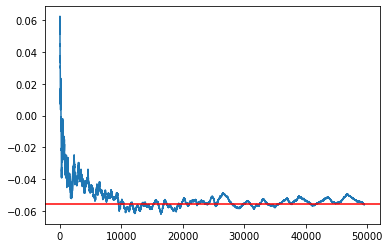

In [6]:
# Kuhn Poker definitions
PASS = 0
BET = 1
NUM_ACTIONS = 2
nodeDict = {}

# Train Kuhn poker
iterations = 50000
avgGameValue = np.zeros(iterations)
cards = np.array([1, 2, 3])
util = 0
with tqdm(total=iterations) as pbar:
    for i in range(0, iterations):
        # Shuffle cards
        np.random.shuffle(cards)
        util = util + cfr(cards, '', 1, 1)
        avgGameValue[i] = util/i
        pbar.update(1)

print('Average game value: ' + str(util/iterations) )
for infoSet, node in nodeDict.items():
    print(node.toString())

# Check with optimital strategy
plt.figure(figsize=(6,4))
plt.plot(avgGameValue[1000:])
plt.xlabel('Algorithm Iterations')
plt.ylabel('Average Game Value')
plt.axhline(y=-1/18, color='r', linestyle='-')
plt.show()